## Predictive Modelling : Multiclassification Problem

## Import of necessary Libraries

In [45]:
import numpy as np
import pandas as pd
import pickle
import os

import matplotlib.pyplot as plt
import seaborn as sns
# Import libraries
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report, average_precision_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, make_scorer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier, plot_importance


from sklearn.metrics import roc_curve, confusion_matrix,precision_recall_curve,confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, fbeta_score, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Modeling
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV,RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE


## Dashboard

In [46]:
scoring = ['precision_weighted']
RSEED = 42
pd.set_option('display.max_columns', 50)
random_state = 100
test_size = 0.3

## Import of Dataset and Set-Up

In [47]:
# Import of dataset after cleaning
df = pd.read_csv('data/df_model.csv')



In [48]:
# Converting Labels  
target_status_group = {'functional':2, 'functional needs repair': 1, 'non functional' : 0}
df['status_group'] = df['status_group'].replace(target_status_group)

In [49]:
df['status_group'].value_counts()

2    32259
0    22824
1     4317
Name: status_group, dtype: int64

In [50]:
# Define predictors and target variable
X = df.drop(["status_group"], axis=1)
y = df["status_group"]

In [51]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size,
                                                        random_state=random_state,
                                                        shuffle=True,
                                                   stratify=y)

In [52]:
X_train.shape


(41580, 22)

## Pipeline for preprocessing

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
amount_tsh           59400 non-null float64
gps_height           59400 non-null float64
longitude            59400 non-null float64
latitude             59400 non-null float64
basin                59400 non-null object
region               59400 non-null object
lga                  59400 non-null object
public_meeting       59400 non-null object
recorded_by          59400 non-null object
scheme_management    59400 non-null object
permit               59400 non-null object
construction_year    59400 non-null int64
payment_type         59400 non-null object
quality_group        59400 non-null object
quantity             59400 non-null object
source               59400 non-null object
waterpoint_type      59400 non-null object
status_group         59400 non-null int64
funder_cat           59400 non-null object
installer_cat        59400 non-null object
extraction_custom    59400 no

In [54]:
# Creating list for categorical predictors/features (used in "Scaling with Preprocessing Pipeline") 
cat_features = list(df.columns[df.dtypes==object])
#cat_features.remove('status_group')
cat_features

['basin',
 'region',
 'lga',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'payment_type',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'funder_cat',
 'installer_cat',
 'extraction_custom',
 'management_custom']

In [55]:
#cat_features.remove('permit')
#cat_features.remove('public_meeting')
#cat_features.remove('lga')
#cat_features.remove('ward')
#cat_features.remove('recorded_by')
#cat_features.remove('region_code')
#num_features.remove('num_private')

In [56]:
cat_features

['basin',
 'region',
 'lga',
 'public_meeting',
 'recorded_by',
 'scheme_management',
 'permit',
 'payment_type',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'funder_cat',
 'installer_cat',
 'extraction_custom',
 'management_custom']

In [57]:
# Creating list for numerical predictors/features (removing target column, used in "Scaling with Preprocessing Pipeline")
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('status_group')
#num_features.remove('district_code')
#num_features.remove('population')
#num_features.remove('region_code')
num_features
#cat_features.remove('status_group')

['amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'construction_year',
 'population_log']

In [58]:
# Pipeline using Pipeline
# Pipeline for numerical features
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(sparse=False))
])

# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [59]:
# transforming the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [60]:
print('train shape: ', X_train_transformed.shape)
print('validation shape: ',X_test_transformed.shape)

train shape:  (41580, 293)
validation shape:  (17820, 293)


## Baseline Model: Dummy Classifier

In [61]:
# DummyClassifier for multiclass target variable 
#(2 = 'functional', 1 = 'functional needs repair', 0 = 'non functional')

dummy = DummyClassifier(strategy='most_frequent', random_state=0)
dummy.fit(X_train_transformed, y_train)
dummy.score(X_test_transformed, y_test)

0.5430976430976431

In [62]:
metrics = ['accuracy', 'precision_weighted', 'recall_weighted']
scores_dummy = cross_validate(dummy, X_train_transformed, y_train, scoring=metrics, cv=5, n_jobs=-1)
print('Mean accuracy: {:.2f}%'.format(scores_dummy['test_accuracy'].mean()*100))
print('Mean precision: {:.2f}%'.format(scores_dummy['test_precision_weighted'].mean()*100))
print('Mean recall: {:.2f}%'.format(scores_dummy['test_recall_weighted'].mean()*100))

Mean accuracy: 54.31%
Mean precision: 29.49%
Mean recall: 54.31%


In [63]:
# Logistic regression (using pipeline)
pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [64]:
y_train_pred = cross_val_predict(pipeline_logreg,X_train,y_train,cv=5)

In [71]:
# Logistic regression (using pipeline, printing results)
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred,average='weighted')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred,average='weighted')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred,average='weighted')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred)))


Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.75
Precision: 0.74
F1 Score: 0.73
Confusion Matrix: 
[[10699   159  5119]
 [  584   447  1991]
 [ 2267   216 20098]]


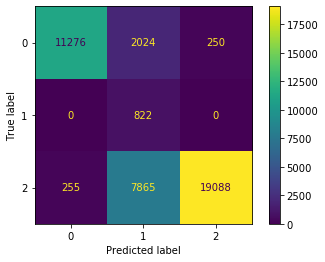

In [81]:
cm = confusion_matrix(y_train, y_train_pred)
plot_confusion_matrix(clf, X_train_transformed, y_train_pred)
plt.show()

In [29]:
# Defining hyperparameters for grid-search (C initial: [0.01, 0.1, 1, 10, 100]; adapted according to optimal results)
param_logreg = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.05, 0.08, 0.1, 0.2, 0.5, 1],
                'logreg__class_weight': [{0: x, 1: 1.0-x} for x in [0.25,0.5,0.75]]
               }

grid_logreg = GridSearchCV(pipeline_logreg, param_grid=param_logreg, cv=5, scoring=scoring, 
                           verbose=5, n_jobs=-1, refit='precision_weighted',return_train_score=True) # scoring can also be "precision", "recall", ...

In [30]:
# Fit model
grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  6.8min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('std_scaler',
                                                                                          StandardScaler(copy=True,
                                                                                                         with_mean=True,
                                    

In [31]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_logreg.best_score_))
print("Best parameters:\n{}".format(grid_logreg.best_params_))

Best score:
0.77
Best parameters:
{'logreg__C': 0.2, 'logreg__class_weight': {0: 0.75, 1: 0.25}, 'logreg__penalty': 'l2'}


In [32]:
# Save best model as best_model
best_model_logreg = grid_logreg.best_estimator_['logreg']

In [33]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_pred_logreg = best_model_logreg.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_logreg)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_logreg,average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_logreg,average='macro')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_logreg,average='macro')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_logreg)))

Accuracy: 0.75
Recall: 0.52
Precision: 0.74
F1 Score: 0.51
Confusion Matrix: 
[[4270    1 2576]
 [ 199    4 1092]
 [ 660    1 9017]]


## Random Forest

**Apply Support Vector Classifier**

In [34]:
# Create model
pipeline_rf_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf_clf', RandomForestClassifier(n_estimators=100,
                              random_state=random_state,
                              max_depth=5,
                              max_features="sqrt",
                              n_jobs=-1,
                              class_weight='balanced',
                              criterion= 'entropy',
                              min_samples_split= 10))
])

In [35]:
y_train_pred_rf_clf = cross_val_predict(pipeline_rf_clf, X_train, y_train, cv=5)

In [36]:
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_pred_rf_clf,average='macro')))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_pred_rf_clf,average='macro')))
print("F1 Score: {:.2f}".format(f1_score(y_train, y_train_pred_rf_clf,average='macro')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_train, y_train_pred_rf_clf)))

Cross validation scores:
-------------------------
Accuracy: 0.64
Recall: 0.61
Precision: 0.57
F1 Score: 0.56
Confusion Matrix: 
[[ 9705  2131  4141]
 [  458  1703   861]
 [ 2664  4814 15103]]


In [37]:
# Defining hyperparameter space for grid-search
param_grid = {'rf_clf__bootstrap': [True, False],
              'rf_clf__max_depth': [2, 3, 5, 10, 20, 30,50,None],
              'rf_clf__max_features': ['auto', 'sqrt',3,5,10,20],
              'rf_clf__min_samples_leaf': [1, 2, 4],
              'rf_clf__min_samples_split': [2, 5, 10],
              'rf_clf__n_estimators': [10, 50, 100, 200, 400]} # Others: kernel, degree (only for poly)
grid_rf_clf = RandomizedSearchCV(pipeline_rf_clf, param_grid, cv=5, scoring=scoring, 
                           verbose=10, n_jobs=-1, refit='precision_weighted',return_train_score=True, n_iter=50)

In [38]:
# Fit on training data
grid_rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  8

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocessor',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('num',
                                                                               Pipeline(memory=None,
                                                                                        steps=[('std_scaler',
                                                                                                StandardScaler(copy=True,
                                                                                           

In [39]:
# Show best parameters
print('Best score:\n{:.2f}'.format(grid_rf_clf.best_score_))
print("Best parameters:\n{}".format(grid_rf_clf.best_params_))

Best score:
0.80
Best parameters:
{'rf_clf__n_estimators': 200, 'rf_clf__min_samples_split': 5, 'rf_clf__min_samples_leaf': 1, 'rf_clf__max_features': 20, 'rf_clf__max_depth': None, 'rf_clf__bootstrap': True}


In [ ]:
# Save best model as best_model
best_model_rf_clf = grid_rf_clf.best_estimator_['rf_clf']

In [ ]:
y_pred_rf_clf = best_model_rf_clf.predict(X_test_transformed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred_rf_clf)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred_rf_clf,average='macro')))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred_rf_clf,average='macro')))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf_clf,average='macro')))
print("Confusion Matrix: \n" + str(confusion_matrix(y_test, y_pred_rf_clf)))

**Final Evaluation**

In [ ]:
('logreg', LogisticRegression(max_iter=1000))

## Classification Models

In [ ]:
import xgboost
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [ ]:
#Create pipeline to use in RandomSearchCV and GridSearchCV
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb_reg', XGBClassifier(n_estimators=110,
                              random_state=random_state,
                              max_depth=5,
                              max_features=20,
                              scoring=scoring,
                              n_jobs=-1))
])

In [46]:


# Select models for comparison
models={#'Baseline': DummyClassifier(strategy='most_frequent'),
        'LogReg': LogisticRegression(max_iter=1000),
        #'KNN': KNeighborsClassifier(),
        #'SVC': SVC(kernel='rbf', C=1E6),
        #'Decision Tree': DecisionTreeClassifier(criterion="gini", max_depth=3,random_state=random_state),
        #'Random Forest': RandomForestClassifier(random_state=random_state, max_features='sqrt', n_jobs=-1),
        #'Gradient Boost': GradientBoostingClassifier(random_state=random_state),
        #'XGBoost': XGBClassifier(),
        #'AdaBoost': AdaBoostClassifier(random_state=random_state)
        'Smote':SMOTE(sampling_strategy='minority')
       }

In [47]:
#scores = cross_validate(models, X_train, y_train, scoring=scoring, cv=3, n_jobs=-1, verbose=10)
# Calculate and display results
results = pd.DataFrame(columns=['Model'])
i = 0
for m in models.items():
    if m == 'Smote':
        X_sm,y_sm = smote.fit_sample(X_train, y_train)
            # Building a full pipeline with our preprocessor and a Classifier
        pipeline = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
    # Making predictions on the training set using cross validation as well as calculating the probabilities
        y_train_pred = cross_val_predict(pipeline,
                                         X_sm,
                                         y_sm.values.ravel(),
                                         cv=5,
                                         verbose=4,
                                         n_jobs=-1)
    else:
        # Building a full pipeline with our preprocessor and a Classifier
        pipeline = Pipeline([('preprocessor', preprocessor), (m[0], m[1])])
        # Making predictions on the training set using cross validation as well as calculating the probabilities
        y_train_pred = cross_val_predict(pipeline,
                                         X_train,
                                         y_train.values.ravel(),
                                         cv=5,
                                         verbose=4,
                                         n_jobs=-1)
    # Calculating metrices
    temp = pd.DataFrame(
        {
            'Model': m[0],
            'Accuracy': accuracy_score(y_train, y_train_pred),
            'Recall': recall_score(y_train, y_train_pred, average="weighted"),
            'Precision': precision_score(y_train, y_train_pred, average="macro"),
            'F1 Score': f1_score(y_train, y_train_pred, average="macro")
            
        },
        index=[i])
    print(f"Confusion Matrix {m[0]}: \n" + str(confusion_matrix(y_train, y_train_pred)))
    i += 1
    results = pd.concat([results, temp])
results

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   36.2s remaining:   54.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.4s finished
/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Confusion Matrix LogReg: 
[[10697   159  5121]
 [  584   447  1991]
 [ 2266   217 20098]]


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s


AttributeError: 'SMOTE' object has no attribute '_validate_data'

## Model 2: SMOTE

In [83]:
k=1
seed=100
sm = SMOTE(sampling_strategy='minority',random_state=seed)
X_res, y_res = sm.fit_resample(X_train_transformed, y_train)

In [84]:

X_train_new, y_train_new = sm.fit_sample(X_train_transformed, y_train)

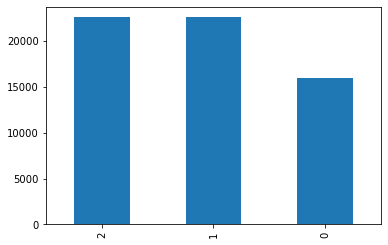

In [85]:

# observe that data has been balanced
pd.Series(y_train_new).value_counts().plot.bar()

In [86]:
clf = LogisticRegression(solver = 'lbfgs')

In [87]:
# fit the model
clf.fit(X_train_new, y_train_new)

# prediction for Training data
train_pred_sm = clf.predict(X_train_new)

# prediction for Testing data
test_pred_sm = clf.predict(X_test_transformed)

/Users/galopito/opt/anaconda3/envs/nf/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [88]:

print('Accuracy score for Training Dataset = ', precision_score(train_pred_sm, y_train_new, average='weighted'))
print('Accuracy score for Testing Dataset = ', precision_score(test_pred_sm, y_test,average='weighted'))


print("Accuracy: {:.2f}".format(accuracy_score(train_pred_sm, y_train_new)))
print("Recall: {:.2f}".format(recall_score(train_pred_sm, y_train_new,average='macro')))
print("Precision: {:.2f}".format(precision_score(train_pred_sm, y_train_new,average='macro')))
print("F1 Score: {:.2f}".format(f1_score(train_pred_sm, y_train_new,average='macro')))
print("Confusion Matrix: \n" + str(confusion_matrix(train_pred_sm, y_train_new)))

Accuracy score for Training Dataset =  0.7064412123790453
Accuracy score for Testing Dataset =  0.664842342859214
Accuracy: 0.70


TypeError: recall_score() got an unexpected keyword argument 'y_train_new'